# Planck Trispectrum Analysis

This notebook implements the Planck temperature trispectrum analysis of Philcox (2023), using measurements from the ```PolyBin``` code. We restrict to large scales ($\ell < 510$) and consider blind tests for parity-violation as well as constraining the amplitudes of various physical models.

### Imports

Let's start by loading modules (note that we don't strictly need both CAMB and CLASS).

In [1]:
%pylab inline
import os, sys, camb, fitsio, emcee
from classy import Class
from scipy.optimize import minimize_scalar
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.integrate import simps
from scipy.stats import chi2 as chi2_dist
from scipy.stats import norm as gaussian

Populating the interactive namespace from numpy and matplotlib


### Parameters

In [2]:
# Directory housing Planck measurements
indir = '/home/ophilcox/cmb-4pt/planck_public/data/'

# Number of simulations
N_fish = 50 # Fisher realizations
N_sim = 300 # FFP10 simulations
N_grf = 1000 # GRF simulations

# Whether to blind data
blind_data = False

# Binning
l_bins = np.load('l_bins_data.npy')
l_bins_squeeze = l_bins.copy()
L_bins = l_bins.copy()

## NB: code to create binning files:
#np.save('l_bins_data.npy',np.asarray([2]+list(np.asarray(np.arange(3**0.4,520**0.4,2**0.4)**2.5,dtype='int'))))
#np.save('l_bins_model.npy',np.asarray(list(np.asarray(np.arange(3**0.4,520**0.4,2**0.4)**2.5,dtype='int'))))

# Number of bins
Nl_squeeze = len(l_bins_squeeze)-1
Nl = len(l_bins)-1
NL = len(L_bins)-1

# Mode counting
Before analyzing the data, let's work out the relative utility of the CMB data as compared to LSS. We will do this via mode counting. First, for the CMB:

In [3]:
# Load CLASS
cosmo = Class()

# Define ell arrays
lmax_analysis = 510
l = np.arange(2,lmax_analysis+1)

# Run CLASS
cosmo.set({'output':'tCl,lCl,mPk,mTk','l_max_scalars':2*lmax_analysis+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'halofit',
           'omega_cdm':0.12011,
           'z_max_pk':1.,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'N_ur':2.0328,
           'T_ncdm':0.71611,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'k_pivot':0.05,
           'YHe':'BBN',
           'n_s':0.96605});
cosmo.compute()

# Load beam
root = '/projects/QUIJOTE/Oliver/planck_maps/'
datafile = 'COM_CMB_IQU-smica_2048_R3.00_full.fits'
beam_dat = fitsio.read(root+datafile,ext=2)['INT_BEAM']
beam_int = InterpolatedUnivariateSpline(np.arange(len(beam_dat)),beam_dat)
beam = beam_int(l)

# Compute signal C_ell, including the beam (avoiding zero errors)
Cl_dict = cosmo.lensed_cl(lmax_analysis);
Cl_true = beam**2*Cl_dict['tt'][2:]*cosmo.T_cmb()**2

# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
thetaFWHM = 5./60.*np.pi/180. # in radians
Cl_tot = Cl_true+DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>=2)

# Compute CMB N-modes
f_sky = 0.781
NmodesCMB = f_sky*np.sum((2*l+1)*Cl_true**2./Cl_tot**2.)
print("CMB (lmax = %d): Nmodes = %.2e"%(lmax_analysis,NmodesCMB))

CMB (lmax = 510): Nmodes = 2.03e+05


We now repeat for LSS, using the approach of Sailer+19, computing only the number of linear modes. We use parameters appropriate to the BOSS analysis of Philcox 22 (and Hou+22). 

In [4]:
# k- and mu-ranges
kmax = 2*np.pi/20.
kmin = 2*np.pi/160.
k_arr = np.linspace(kmin,kmax,1000)[:,None]
mu_arr = np.linspace(-1,1,1000)[None,:]

# Define redshift and sky fraction
fsky = 9376.09/41253. # from 1509.06371
zmin = 0.43
zmax = 0.70

## Survey volume
def comov_vol(zmin,zmax,fsky,h):
    '''
    Returns the comoving volume in Mpc^3/h^3 between 
    zmin and zmax assuming that the universe is flat.
    Includes the fsky of the experiment.
    '''
    vsmall = (4*np.pi/3) * ((1.+zmin)*cosmo.angular_distance(zmin))**3.
    vbig = (4*np.pi/3) * ((1.+zmax)*cosmo.angular_distance(zmax))**3.
    return fsky*(vbig - vsmall)*h**3.

Vz = comov_vol(zmin,zmax,fsky,cosmo.h())
z_av = (zmin+zmax)/2.
fz = cosmo.scale_independent_growth_factor_f(z_av)

# Bias and number density
b1 = 2.0
kaiser = (b1+fz*mu_arr**2)
nbar = 3e-4

# Power spectra (linear + halofit)
Plin = np.asarray([cosmo.pk_lin(kk*cosmo.h(),z_av)*cosmo.h()**3. for kk in k_arr])
Phf = np.asarray([cosmo.pk(kk*cosmo.h(),z_av)*cosmo.h()**3. for kk in k_arr])

# Zeldovich displacement amplitude
k_all = np.logspace(-5,0.8,1000)
Plin_all = np.asarray([cosmo.pk_lin(kk*cosmo.h(),z_av)*cosmo.h()**3. for kk in k_all])
Sig = simps(Plin_all/(6.*np.pi**2.),k_all)

# Correlated and total power spectra
PL = Plin[:,None]*kaiser**2.
PNL = Phf[:,None]*kaiser**2.
Gkmu = np.exp(-0.5*(k_arr**2*(1.-mu_arr**2)+k_arr**2.*mu_arr**2*(1.+fz)**2.)*Sig**2)

# Compute integrals and find N_modes
integ = (Gkmu**2*PL/(PNL+1./nbar))**2*k_arr**2/(4.*np.pi**2.)
NmodesLSS = Vz*simps(simps(integ,k_arr,axis=0),mu_arr.ravel())
print("LSS (k = [%.3f,%.3f]): Nmodes = %.2e"%(kmin,kmax,NmodesLSS))

LSS (k = [0.039,0.314]): Nmodes = 7.67e+02


Notably, the LSS data contains *far* fewer modes! This is primarily due to the decorrelation from Zel'dovich displacements.

# Analysis
We now proceed to the Planck analysis. First, let's define some filters which pick out the bins we are interested in.

In [5]:
# Define minimum/maximum bins
bmin = 1
bmax = Nl-1
print("l_min = %d, l_max = %d"%(l_bins[bmin],l_bins[bmax+1]))

def _check_bin(bin1, bin2, bin3, even=False):
    """
    Return one if modes in the bin satisfy the triangle conditions, or zero else.

    If even=true, we enforce that the sum of the three ells must be even.

    This is used either for all triangles in the bin, or just the center of the bin.
    """
    l1 = 0.5*(l_bins_squeeze[bin1]+l_bins_squeeze[bin1+1])
    l2 = 0.5*(l_bins_squeeze[bin2]+l_bins_squeeze[bin2+1])
    l3 = 0.5*(l_bins_squeeze[bin3]+l_bins_squeeze[bin3+1])
    if l3<abs(l1-l2) or l3>l1+l2:
        return 0
    else:
        return 1
    
def compute_filt(bmin, bmax, include_even=True):
    """Compute a filter determining which bins to keep."""
    filt = []
    if include_even:
        # Iterate over bins
        for bin1 in range(Nl):
            for bin2 in range(bin1,Nl_squeeze):
                for bin3 in range(bin1,Nl):
                    for bin4 in range(bin3,Nl_squeeze):
                        if bin1==bin3 and bin4<bin2: continue

                        # Iterate over L bins
                        for binL in range(NL):
                            # skip bins outside the triangle conditions
                            if not _check_bin(bin1,bin2,binL,even=False): continue
                            if not _check_bin(bin3,bin4,binL,even=False): continue

                            if bin1<bmin or bin2<bmin or bin3<bmin or bin4<bmin or binL<bmin or bin1>bmax or bin2>bmax or bin3>bmax or bin4>bmax or binL>bmax:
                                filt.append(False)
                            else:
                                filt.append(True)
    N_t_even = np.sum(filt)
    # Iterate over bins
    for bin1 in range(Nl):
        for bin2 in range(bin1,Nl_squeeze):
            for bin3 in range(bin1,Nl):
                for bin4 in range(bin3,Nl_squeeze):
                    if bin1==bin3 and bin4<=bin2: continue

                    # Iterate over L bins
                    for binL in range(NL):
                        # skip bins outside the triangle conditions
                        if not _check_bin(bin1,bin2,binL,even=False): continue
                        if not _check_bin(bin3,bin4,binL,even=False): continue

                        if bin1<bmin or bin2<bmin or bin3<bmin or bin4<bmin or binL<bmin or bin1>bmax or bin2>bmax or bin3>bmax or bin4>bmax or binL>bmax:
                            filt.append(False)
                        else:
                            filt.append(True)
    N_t_odd = np.sum(filt)-N_t_even
    return filt, N_t_even, N_t_odd

# Number of bins in use
filt, N_t_even, N_t_odd = compute_filt(bmin, bmax)
# Total number of bins
_, Np_t_even, Np_t_odd = compute_filt(0, Nl_squeeze-1)

print("Using %d of %d bins, of which %d are parity-odd"%(np.sum(filt),len(filt), N_t_odd))

l_min = 3, l_max = 510
Using 1008 of 1273 bins, of which 460 are parity-odd


### Fisher Matrices
We now load the 50 realizations of the Fisher Matrix and average them together. Note that, in practice, far fewer realizations can be used - the results are unchanged with just 5 realizations.

Averaging 50 Fisher matrix realizations


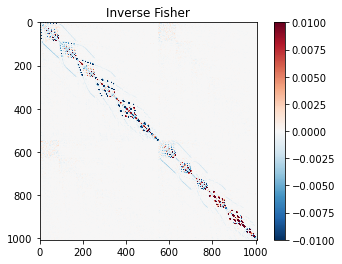

In [6]:
### Load Fisher matrix
fish_raw = 0.
ct = 0
for i in range(N_fish):
    infile = indir+'trispectrum_fisher%d_(%d,%d,%d).npy'%(i,Nl,Nl_squeeze,NL)
    if not os.path.exists(infile): continue
    this_fish = np.load(infile)
    fish_raw += this_fish
    ct += 1

fish_raw /= ct
print("Averaging %d Fisher matrix realizations"%ct)

# Invert matrix and filter to relevant bins (even + odd parity)
inv_fish_raw = np.linalg.inv(fish_raw)
inv_fish = inv_fish_raw[filt][:,filt]

# Compute Cholesky factorization (after projection)
half_inv = np.linalg.cholesky(np.linalg.inv(inv_fish)).T

# Plot matrix
fplot = inv_fish_raw[filt][:,filt].copy()
cplot = fplot/np.sqrt(np.outer(np.diag(fplot),np.diag(fplot)))
v = 1e-2
plt.imshow(cplot-np.eye(len(cplot)),vmax=v,vmin=-v,cmap=cm.RdBu_r)
plt.colorbar();
plt.title('Inverse Fisher');

### Load trispectra
Next, we load the trispectrum data from Planck, the FFP10 simulations and the GRF simulations. If we turned on blinding, the Planck data will be replaced by the first FFP10 simulation.

In [7]:
### Load data
if blind_data:
    data_index = 0
    min_sim = 1 
    print("Loading simulation %d as data"%data_index)
else:
    min_sim = 0
    data_index = -1
    print("Loading Planck data")
infile = indir+'trispectrum100_numerator%d_(%d,%d,%d).txt'%(data_index,Nl,Nl_squeeze,NL)
if not os.path.exists(infile): raise Exception("Data not found!")
datD = np.loadtxt(infile)
numD_even, numD_odd = datD[:Np_t_even],datD[Np_t_even:]
tlD_both = np.matmul(inv_fish_raw,datD)

### Load FFP10 trispectra
nums_even, nums_odd = [],[]
tl_all = []
ct = 0
ids = []
for i in range(min_sim,N_sim):
    infile = indir+'trispectrum100_numerator%d_(%d,%d,%d).txt'%(i,Nl,Nl_squeeze,NL)
    if not os.path.exists(infile): continue
    dat = np.loadtxt(infile)
    nums_even.append(dat[:Np_t_even])
    nums_odd.append(dat[Np_t_even:])
    Tl_both = np.matmul(inv_fish_raw,dat)
    tl_all.append(Tl_both)
    ids.append(i)
    ct += 1
print("Loaded %d FFP10 simulations"%ct)

### Load GRF trispectra
numsG_even, numsG_odd = [],[]
tlG_all = []
ctG = 0
for i in range(N_grf):
    infile = indir+'trispectrum100_grf-numerator%d_(%d,%d,%d).txt'%(i,Nl,Nl_squeeze,NL)
    if not os.path.exists(infile): continue
    datG = np.loadtxt(infile)
    #except IOError:
    #    print("IO Error for simulation %d"%i)
    #    continue
    if np.isnan(datG).sum()+np.isnan(datG[1]).sum()>0:
        print("NaN Error for GRF %d"%i)
        continue
    numsG_even.append(datG[:Np_t_even])
    numsG_odd.append(datG[Np_t_even:])
    TlG_both = np.matmul(inv_fish_raw,datG)
    tlG_all.append(TlG_both)
    ctG += 1
print("Loaded %d GRF simulations"%ctG)

# Filter to correct shapes
tl_all = np.asarray(tl_all)[:,filt]
tlG_all = np.asarray(tlG_all)[:,filt]
assert len(tl_all[0])==N_t_even+N_t_odd
assert len(tlG_all[0])==N_t_even+N_t_odd
tl_even = tl_all[:,:N_t_even]
tl_odd = tl_all[:,N_t_even:]
tlG_even = tlG_all[:,:N_t_even]
tlG_odd = tlG_all[:,N_t_even:]
tlD_both = tlD_both[filt]
tlD_even = tlD_both[:N_t_even]
tlD_odd = tlD_both[N_t_even:]

# Compute normalized trispectrum
tauD = half_inv@tlD_both
tauG = half_inv@tlG_all.T
tau = half_inv@tl_all.T

# Compute normalized trispectrum using only odd components of inverse Fisher
half_inv_odd = np.linalg.cholesky(np.linalg.inv(inv_fish[N_t_even:,N_t_even:])).T
tauD_odd = half_inv_odd@tlD_odd
tau_odd = half_inv_odd@tl_odd.T
tauG_odd = half_inv_odd@tlG_odd.T

# Compute numerical covariance matrices
covNum = np.cov(tl_all.T)
covNumG = np.cov(tlG_all.T)
cov_half = np.cov(tau)
cov_halfG = np.cov(tauG)

Loading Planck data
Loaded 300 FFP10 simulations
Loaded 1000 GRF simulations


### Plots: Data 
Let's see what the data looks like (for both even- and odd-parity).

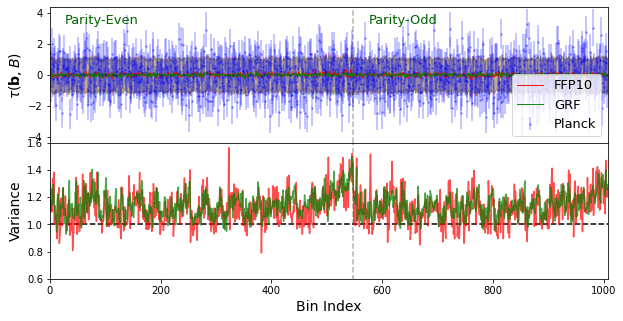

In [8]:
fig,ax=plt.subplots(2,1,figsize=(10,5),sharex=True)
plt.subplots_adjust(hspace=0)

### Plot data
# Planck
ax[0].errorbar(np.arange(N_t_even+N_t_odd),tauD,c='b',label='Planck',alpha=0.3,ls='',yerr=tau.std(axis=1),marker='.',ms=3)
# FFP10 
ax[0].plot(tau.mean(axis=1),c='r',label='FFP10',alpha=0.9,lw=1)
ax[0].fill_between(np.arange(N_t_even+N_t_odd),
                   tau.mean(axis=1)-tau.std(axis=1),tau.mean(axis=1)+tau.std(axis=1),color='r',alpha=0.25)
# GRF
ax[0].plot(tauG.mean(axis=1),c='g',label='GRF',alpha=0.9,lw=1)
ax[0].fill_between(np.arange(N_t_even+N_t_odd),
                   tauG.mean(axis=1)-tauG.std(axis=1),tauG.mean(axis=1)+tauG.std(axis=1),color='g',alpha=0.25)

### Plot variances
# FFP10 
ax[1].plot(np.diag(cov_half),c='r',alpha=0.7)
# GRF
ax[1].plot(np.diag(cov_halfG),c='g',alpha=0.7)
    
### Cosmetics
yval = np.max(np.std(tau,axis=1))*3.5
ax[0].vlines(N_t_even,-yval,yval,color='k',alpha=0.3,ls='--')
ax[0].set_ylim(-yval,yval)
ax[0].set_xlim(0,N_t_even+N_t_odd)
ax[0].text(N_t_even*0.05,0.75*yval,'Parity-Even',c='darkgreen',fontsize=13)
ax[0].text(N_t_even*1.05,0.75*yval,'Parity-Odd',c='darkgreen',fontsize=13)
ax[0].set_xlabel(r'Bin Index',fontsize=14)
ax[0].set_ylabel(r'$\tau(\mathbf{b},B)$',fontsize=14)
ax[0].legend(fontsize=13,loc='lower right')
ax[1].hlines(1,0,N_t_even+N_t_odd,color='k',ls='--')
ax[1].vlines(N_t_even,0,4,color='k',alpha=0.3,ls='--')
ax[1].set_ylim(0.6,1.6)
ax[1].set_ylabel(r'Variance',fontsize=14)
ax[1].set_xlabel(r'Bin Index',fontsize=14);

We find good agreement between FFP10 and GRF simulations, with a variance which is close to the predicted value of $1$. The Planck data seems consistent with the simulations, but we'll check this in greater detail below.

Let's repeat the plotting just for the parity-odd modes:

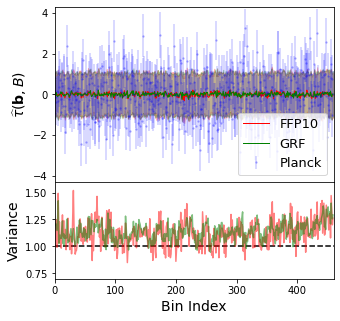

In [9]:
fig,ax=plt.subplots(2,1,figsize=(5,5),sharex=True,gridspec_kw={'height_ratios': [1.8, 1]})
plt.subplots_adjust(hspace=0)

### Plot data
# Planck
ax[0].errorbar(np.arange(N_t_odd),tauD_odd,c='b',label='Planck',alpha=0.2,ls='',yerr=tau_odd.std(axis=1),marker='.',ms=3)
# FFP10
ax[0].plot(tau_odd.mean(axis=1),c='r',label='FFP10',alpha=1.,lw=1)
ax[0].fill_between(np.arange(N_t_odd),
                   tau_odd.mean(axis=1)-tau_odd.std(axis=1),tau_odd.mean(axis=1)+tau_odd.std(axis=1),color='r',alpha=0.25)
# GRF
ax[0].plot(tauG_odd.mean(axis=1),c='g',label='GRF',alpha=1.,lw=1)
ax[0].fill_between(np.arange(N_t_odd),
                   tauG_odd.mean(axis=1)-tauG_odd.std(axis=1),tauG_odd.mean(axis=1)+tauG_odd.std(axis=1),color='g',alpha=0.25)

### Plot variances
half_inv_odd = np.linalg.cholesky(np.linalg.inv(inv_fish[N_t_even:,N_t_even:])).T
cov_half_odd = np.cov(half_inv_odd@tl_odd.T)
cov_half_oddG = np.cov(half_inv_odd@tlG_odd.T)
# FFP10 
ax[1].plot(np.diag(cov_half_odd),c='r',alpha=0.5)
# GRF
ax[1].plot(np.diag(cov_half_oddG),c='g',alpha=0.5)

### Cosmetics
ax[0].legend(fontsize=13,loc='lower right')
yval = np.max(np.std(tau_odd,axis=1))*3.5
ax[0].set_ylim(-yval,yval)
ax[0].set_xlim(0,N_t_odd)
ax[0].set_xlabel(r'Bin Index',fontsize=14)
ax[0].set_ylabel(r'$\widehat{\tau}(\mathbf{b},B)$',fontsize=14)
ax[1].hlines(1,0,N_t_even+N_t_odd,color='k',ls='--')
ax[1].vlines(N_t_even,0,4,color='k',alpha=0.3,ls='--')
ax[1].set_ylim(0.7,1.6)
ax[1].set_ylabel(r'Variance',fontsize=14)
ax[1].set_xlabel(r'Bin Index',fontsize=14);

# Save output
fig.savefig('plots/tau_plot.pdf',bbox_inches='tight')

### Plots: Covariance

Let's compare the trispectrum variances explicitly (without projecting onto the normalized trispectrum $\tau$).

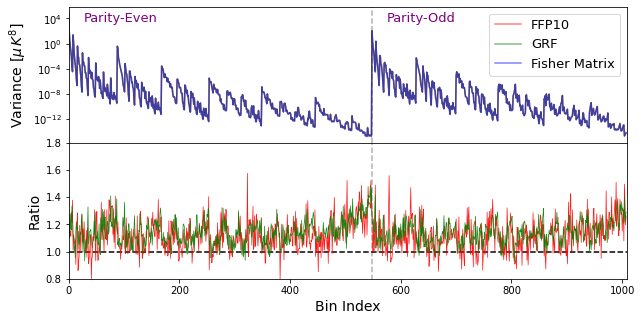

In [10]:
fig,ax=plt.subplots(2,1,figsize=(10,5),sharex=True)
sc = (1e6)**8

plt.subplots_adjust(hspace=0)
# FFP10
ax[0].plot(np.diag(covNum)*sc,c='r',label='FFP10',alpha=0.5)
# GRF
ax[0].plot(np.diag(covNumG)*sc,c='g',label='GRF',alpha=0.5)
# Fisher
ax[0].plot(np.diag(inv_fish)*sc,c='b',label='Fisher Matrix',alpha=0.5)

# Cosmetics
ax[0].legend(fontsize=13)
ax[0].vlines(N_t_even,0.1*np.min(np.diag(inv_fish))*sc,10*np.max(np.diag(inv_fish))*sc,color='k',alpha=0.3,ls='--')
ax[0].set_ylim(0.1*np.min(np.diag(inv_fish))*sc,10*np.max(np.diag(inv_fish))*sc)
ax[0].set_xlim(0,N_t_even+N_t_odd)
ax[0].text(N_t_even*0.05,0.05*np.max(np.diag(inv_fish))*sc,'Parity-Even',c='purple',fontsize=13)
ax[0].text(N_t_even*1.05,0.05*np.max(np.diag(inv_fish))*sc,'Parity-Odd',c='purple',fontsize=13)
ax[0].set_yscale('log')
ax[0].set_xlabel(r'Bin Index',fontsize=14)
ax[0].set_ylabel(r'Variance [$\mu\,K^8$]',fontsize=14)
ax[1].plot(np.diag(covNum)/np.diag(inv_fish),c='r',alpha=0.9,lw=0.7)
ax[1].plot(np.diag(covNumG)/np.diag(inv_fish),c='g',alpha=0.9,lw=0.7)
ax[1].hlines(1,0,N_t_even+N_t_odd,color='k',ls='--')
ax[1].vlines(N_t_even,0.5,4,color='k',alpha=0.3,ls='--')
ax[1].set_ylim(0.8,1.8)
ax[1].set_ylabel(r'Ratio',fontsize=14)
ax[1].set_xlabel(r'Bin Index',fontsize=14);

# Save output
fig.savefig('plots/cov_all.pdf',bbox_inches='tight')

We can also look at the correlation matrix structure. Here we plot the (correlation of the) inverse Fisher matrix of $t$ (which has structure due to bin correlations), and the empirical correlation matrix of $t$. In the latter case, the theoretical expectation is a unit matrix.

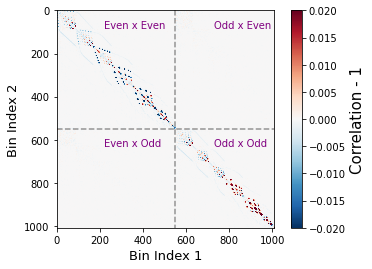

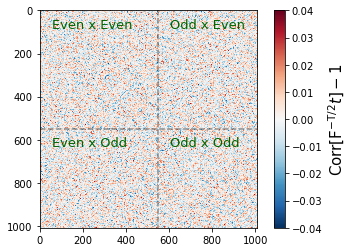

In [11]:
# Plot theoretical inverse Fisher matrix
fplot = inv_fish_raw[filt][:,filt].copy()
cplot = fplot/np.sqrt(np.outer(np.diag(fplot),np.diag(fplot)))
v = 0.02
plt.imshow(cplot-np.eye(len(cplot)),vmax=v,vmin=-v,cmap=cm.RdBu_r)
cbar = plt.colorbar();
cbar.set_label(r"Correlation - 1",fontsize=15)
fs = 10
plt.text(N_t_even*0.4,N_t_even*0.15,'Even x Even',c='purple',fontsize=fs)
plt.text(N_t_even*0.4,N_t_even+N_t_even*0.15,'Even x Odd',c='purple',fontsize=fs)
plt.text(N_t_even+N_t_even*0.33,N_t_even*0.15,'Odd x Even',c='purple',fontsize=fs)
plt.text(N_t_even+N_t_even*0.33,N_t_even+N_t_even*0.15,'Odd x Odd',c='purple',fontsize=fs)
plt.vlines(N_t_even,0,N_t_even+N_t_odd,ls='--',color='k',alpha=0.4)
plt.hlines(N_t_even,0,N_t_even+N_t_odd,ls='--',color='k',alpha=0.4)
plt.xlabel(r'Bin Index 1',fontsize=13)
plt.xlim(0,N_t_even+N_t_odd)
plt.ylim(N_t_even+N_t_odd,0)
plt.ylabel(r'Bin Index 2',fontsize=13);
plt.savefig('plots/t_corr.pdf',bbox_inches='tight')

# Plot numerical covariance matrix of tau (should be unity)
v = 0.04
chalf = cov_half/np.sqrt(np.outer(np.diag(cov_half),np.diag(cov_half)))
plt.figure()
plt.imshow((chalf-np.eye(len(chalf))),cmap=cm.RdBu_r,vmax=v,vmin=-v);
plt.vlines(N_t_even,0,N_t_even+N_t_odd,ls='--',color='k',alpha=0.4)
plt.hlines(N_t_even,0,N_t_even+N_t_odd,ls='--',color='k',alpha=0.4)
plt.xlim(0,N_t_even+N_t_odd)
plt.ylim(N_t_even+N_t_odd,0)
plt.text(N_t_even*0.1,N_t_even*0.15,'Even x Even',c='darkgreen',fontsize=13)
plt.text(N_t_even*0.1,N_t_even+N_t_even*0.15,'Even x Odd',c='darkgreen',fontsize=13)
plt.text(N_t_even+N_t_even*0.1,N_t_even*0.15,'Odd x Even',c='darkgreen',fontsize=13)
plt.text(N_t_even+N_t_even*0.1,N_t_even+N_t_even*0.15,'Odd x Odd',c='darkgreen',fontsize=13)
cbar = plt.colorbar();
cbar.set_label(r"$\mathrm{Corr}\left[\mathsf{F}^{-\mathrm{T}/2}t\right] - 1$",fontsize=15)

Let's plot the odd components of the second matrix in more detail, using both simulations. This is consistent with the unit matrix!

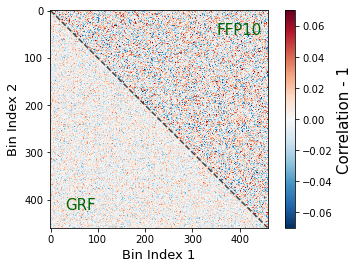

In [12]:
tauG_odd = half_inv_odd@tlG_odd.T
covG_t_odd = np.cov(tauG_odd)
corrG_half = covG_t_odd/np.sqrt(np.outer(np.diag(covG_t_odd),np.diag(covG_t_odd)))
cov_t_odd = np.cov(tau_odd)
corr_half = cov_t_odd/np.sqrt(np.outer(np.diag(cov_t_odd),np.diag(cov_t_odd)))
v = 0.07
plt.imshow(corrG_half-np.eye(len(corrG_half)),cmap=cm.RdBu_r,vmax=v,vmin=-v);
#plt.imshow(np.tril(corrG_half)-np.eye(len(corrG_half)),cmap=cm.RdBu_r,vmax=v,vmin=-v);
plt.imshow(np.tril(corrG_half)+np.triu(corr_half)-np.eye(len(corrG_half))-np.eye(len(corrG_half)),cmap=cm.RdBu_r,vmax=v,vmin=-v);
plt.plot(np.arange(0,len(corrG_half)),ls='--',c='k',alpha=0.7)
plt.text(30,420,'GRF',color='darkgreen',fontsize=15)
plt.text(350,50,'FFP10',color='darkgreen',fontsize=15)
cbar = plt.colorbar();
cbar.set_label(r"Correlation - 1",fontsize=15)
plt.xlabel(r'Bin Index 1',fontsize=13)
plt.ylabel(r'Bin Index 2',fontsize=13);
plt.savefig('plots/tau_corr.pdf',bbox_inches='tight')

### Blind Test for Parity-Violation
We proceed to perform the blind $\chi^2$ test for parity violation. We will compute $\chi^2$ from the data and simulations and compare both to the theoretical and empirical distributions.

GRF rank: 357 / 1000;  p = 0.36; sigma = -0.37
FFP10 rank: 128 / 300;  p = 0.43; sigma = -0.18


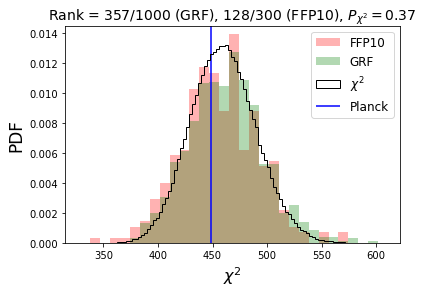

In [13]:
# Compute chi^2 values
chi2 = np.sum(tau_odd**2./np.var(tauG_odd,axis=1)[:,np.newaxis],axis=0)
chi2D = np.sum(tauD_odd**2/np.var(tauG_odd,axis=1))
chi2G = np.sum(tauG_odd**2/np.var(tauG_odd,axis=1)[:,np.newaxis],axis=0)

# Compute rank of data
# Rank wrt GRF
sort_chi2 = np.sort(chi2G)
rank1 = np.where(chi2D>sort_chi2)[0][-1]
if rank1==len(chi2G)-1:
    rank_grf = len(chi2G)
else:
    low = sort_chi2[rank1]
    high = sort_chi2[rank1+1]
    rank_grf = rank1 + (chi2D-low)/(high-low)
print("GRF rank: %d / %d;  p = %.2f; sigma = %.2f"%(rank_grf,len(chi2G),rank_grf/len(chi2G),gaussian.ppf(rank_grf/len(chi2G))))
# Rank wrt FFP10
sort_chi2 = np.sort(chi2)
rank1 = np.where(chi2D>sort_chi2)[0][-1]
low = sort_chi2[rank1]
high = sort_chi2[rank1+1]
rank_ffp10 = rank1 + (chi2D-low)/(high-low)
print("FFP10 rank: %d / %d;  p = %.2f; sigma = %.2f"%(rank_ffp10,len(chi2),rank_ffp10/len(chi2),gaussian.ppf(rank_ffp10/len(chi2))))
# chi^2 probability
p_chi2D = chi2_dist.cdf(chi2D,N_t_odd)

chi2_samples = chi2_dist.rvs(N_t_odd,size=len(tau[0])*500)
plt.hist(chi2,density=True,bins=30,alpha=0.3,color='r',label='FFP10',range=[0.95*min(chi2),1.05*max(chi2)]);
plt.hist(chi2G,density=True,bins=30,alpha=0.3,color='g',label='GRF',range=[0.95*min(chi2),1.05*max(chi2)]);
x,y,_=plt.hist(chi2_samples,histtype='step',alpha=1.,density=True,bins=100,color='k',label=r'$\chi^2$');
plt.vlines(chi2D,0,1.5*max(x),color='b',label='Planck')
plt.ylim(0,1.1*max(x))
#plt.xlim(330,620)#min(chi2)*0.95,1.03*max(chi2))
plt.xlabel(r'$\chi^2$',fontsize=16)
plt.ylabel(r'PDF',fontsize=17);
plt.legend(fontsize=12);
plt.title("Rank = %d/%d (GRF), %d/%d (FFP10), $P_{\chi^2}=%.2f$"%(rank_grf,len(chi2G),rank_ffp10,len(chi2),p_chi2D),fontsize=14);
plt.savefig('plots/chi2_prob.pdf',bbox_inches='tight')

The Planck data is fully consistent with the simulations, and the two sets of simulations are also fully consistent. We find a small degree of evidence for a non-Gaussian likelihood: this is emphasized by using more $\ell$-bins (at fixed $\ell_{\rm max}$).

To test the consistency of FFP10 and GRF simulations, we can compare the rank of each FFP10 simulation relative to the GRFs.

Mean rank: 0.465 +- 0.017, Expectation: 0.500 +- 0.017


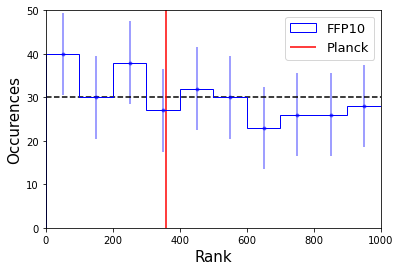

In [14]:
# Compute rank of each simulation
sort_chi2G = np.sort(chi2G)
ranks = []
for i in range(len(chi2)):
    rank1 = np.where(chi2[i]>sort_chi2G)[0]
    if len(rank1)==0:
        rank_i = len(chi2G)
    else:
        rank1 = rank1[-1]
        if rank1==len(chi2G)-1:
            rank_i = len(chi2G)
        else:
            low = sort_chi2G[rank1]
            high = sort_chi2G[rank1+1]
            rank_i = rank1 + (chi2[i]-low)/(high-low)
    ranks.append(rank_i)
    
# Repeat also for Planck data
rank1 = np.where(chi2D>sort_chi2G)[0]
if len(rank1)==0:
    rank_i = len(chi2G)
else:
    rank1 = rank1[-1]
    if rank1==len(chi2G)-1:
        rankD = len(chi2G)
    else:
        low = sort_chi2G[rank1]
        high = sort_chi2G[rank1+1]
        rankD = rank1 + (chi2D-low)/(high-low)

# Compute summaries
mean_rank = np.mean(np.asarray(ranks)/len(chi2G))
std_rank = np.std(np.asarray(ranks)/len(chi2G))/np.sqrt(len(ranks))
print("Mean rank: %.3f +- %.3f, Expectation: %.3f +- %.3f"%(mean_rank,std_rank,0.5,1./np.sqrt(12.*len(ranks))))

# Plot ranks
plt.hist(ranks,range=[0,len(chi2G)],bins=10,histtype='step',density=False,color='b',label='FFP10')
y,x = np.histogram(ranks,range=[0,len(chi2G)],bins=10)
plt.errorbar(0.5*(x[1:]+x[:-1]),y,yerr=3./10.*np.sqrt(len(chi2G)),ls='',c='b',alpha=0.5,marker='.')
plt.xlim([0,len(chi2G)])
plt.hlines(len(chi2)/10,0,len(chi2G),linestyles='--',color='k')
plt.xlabel(r'Rank',fontsize=15)
plt.vlines(rankD,0,50,color='r',label='Planck')
plt.legend(fontsize=13)
plt.ylim([0,50])
plt.ylabel(r'Occurences',fontsize=15)
plt.savefig('plots/ffp10_ranks.pdf',bbox_inches='tight')

### Compare Model Constraints
We now load the theoretical models and compute the constraints on there amplitudes via MCMC. We can optionally remove bins from the analysis using the template below.

In [35]:
# Compute filter to optionally remove highest bin
bmin_model = 0
bmax_model = Nl
hi_filt = []
# Iterate over bins
for bin1 in range(1,Nl):
    for bin2 in range(max(bin1,1),Nl_squeeze):
        for bin3 in range(max(bin1,1),Nl):
            for bin4 in range(max(bin3,1),Nl_squeeze):
                if bin1==bin3 and bin4<=bin2: continue

                # Iterate over L bins
                for binL in range(1,NL):#-1):
                    # skip bins outside the triangle conditions
                    if not _check_bin(bin1,bin2,binL,even=False): continue
                    if not _check_bin(bin3,bin4,binL,even=False): continue

                    if bin1<bmin_model or bin2<bmin_model or bin3<bmin_model or bin4<bmin_model or binL<bmin_model:
                        hi_filt.append(False)
                    elif bin1>=bmax_model or bin2>=bmax_model or bin3>=bmax_model or bin4>=bmax_model or binL>=bmax_model:
                        hi_filt.append(False)
                    else:
                        hi_filt.append(True)
print("Using %d of %d bins"%(np.sum(hi_filt),len(hi_filt)))
            
def load_model(name):
    """Load model and add T_CMB^4 factor"""
    tl_model = np.loadtxt('%s'%name)

    return np.asarray(tl_model[hi_filt])*2.7255**4.

# Compute normalization factor
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.32, ombh2=0.022383, omch2=0.12011,tau=0.0543,mnu=0.06,omk=0,standard_neutrino_neff=True)
As = 1e-10*np.exp(3.0448)
pars.InitPower.set_params(ns=0.96605,r=0.,pivot_scalar=0.05,As=As)
DeltaSq_zeta = As*2*np.pi**2 # primordial amplitude (from Planck)

# Load models
tl_gauge = load_model('models/gauge_model.txt')
tl_ghost = load_model('models/ghost_model.txt')/DeltaSq_zeta**3.
tl_ghost1 = tl_ghost[:,0]
tl_ghost2 = tl_ghost[:,1]
tl_collider1 = load_model('models/collider_model_1.00,0.75.txt')/DeltaSq_zeta**4.
tl_collider2 = load_model('models/collider_model_1.00,0.00.txt')/DeltaSq_zeta**4.
tl_collider3 = load_model('models/collider_model_1.00,1.25.txt')/DeltaSq_zeta**4.
tl_collider4 = load_model('models/collider_model_0.10,0.75.txt')/DeltaSq_zeta**4.
tl_collider5 = load_model('models/collider_model_10.00,0.75.txt')/DeltaSq_zeta**4.
                        
# Compute projection matrix
filt_inv_fish = inv_fish[N_t_even:,N_t_even:][hi_filt][:,hi_filt]
proj_matrix = np.linalg.cholesky(np.linalg.inv(filt_inv_fish)).T

# Project model 
tau_ghost1 = proj_matrix@tl_ghost[:,0]
tau_ghost2 = proj_matrix@tl_ghost[:,1]
tau_gauge = proj_matrix@tl_gauge
tau_collider1 = proj_matrix@tl_collider1
tau_collider2 = proj_matrix@tl_collider2
tau_collider3 = proj_matrix@tl_collider3
tau_collider4 = proj_matrix@tl_collider4
tau_collider5 = proj_matrix@tl_collider5

Using 460 of 460 bins


Let's plot the theoretical models:

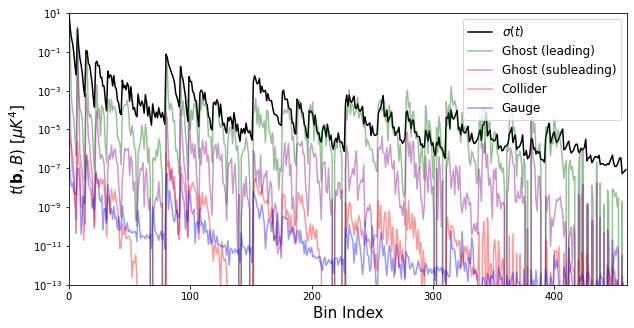

In [36]:
plt.figure(figsize=(10,5))
sc = (1e6)**4
plt.plot(sc*tl_odd.std(axis=0)[hi_filt],label=r'$\sigma(t)$',c='k');
plt.yscale('log')
plt.plot(sc*np.abs(tl_ghost1)*1e-9,c='darkgreen',alpha=0.4,label=r'Ghost (leading)')#, $\times 10^{10})$')
plt.plot(sc*np.abs(tl_ghost2)*1e-11,c='purple',alpha=0.4,label=r'Ghost (subleading)')#, $\times 10^{10})$')
plt.plot(sc*np.abs(tl_collider1)*1e-13,alpha=0.4,c='r',label=r'Collider')# $(\times 10^{7})$',c='r')
plt.plot(sc*np.abs(tl_gauge)*1e3,alpha=0.4,c='b',label=r'Gauge')# $(\times 10^{10})$')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylim([1e-13,1e1])
plt.ylabel(r'$t(\mathbf{b},B)\,\,[\mu K^4]$',fontsize=15);
plt.legend(fontsize=12);
plt.xlim([0,np.sum(hi_filt)]);
plt.savefig('plots/tl_models.pdf',bbox_inches='tight')

We now compute the MCMC samples using ```emcee```.

In [39]:
# Likelihood
tau_var = np.var(proj_matrix@tlG_odd.T[hi_filt],axis=1)
tau_mean = np.mean(proj_matrix@tl_odd.T[hi_filt],axis=1)
tauD = proj_matrix@tlD_odd[hi_filt]

def compute_samples(tau_model, tau_data, name=''):

    loglik_A = lambda A: np.sum((tau_data-A*tau_model)**2/tau_var)

    init = minimize_scalar(loglik_A).x
    if init==0:
        init = minimize_scalar(lambda rA: loglik_A(1e-10*rA)).x*1e-10
    print("Initial guess: %.2e"%init)
    
    pos = np.random.randn(32, 1)*init*10
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lambda A: -loglik_A(A))
    sampler.run_mcmc(pos, 50000);

    flat_samples = sampler.flatchain[1000::10,0]
    
    # Print constraints
    std = flat_samples.std(axis=0)
    mean = flat_samples.mean(axis=0)
    print("%s: (%.2f +- %.2f) x 10^%d"%(name,mean/10**(np.floor(np.log10(std))),std/10**(np.floor(np.log10(std))),np.floor(np.log10(std))))
    return flat_samples

print("Computing Gauge samples")
samples_mean_gauge = compute_samples(tau_gauge, tau_mean,'Gauge-Mean')
samplesD_gauge = compute_samples(tau_gauge, tauD,'Gauge-Data')
print("Computing Ghost-I samples")
samples_mean_ghost1 = compute_samples(tau_ghost1, tau_mean,'Ghost1-Mean')
samplesD_ghost1 = compute_samples(tau_ghost1, tauD,'Ghost1-Data')
print("Computing Ghost-II samples")
samples_mean_ghost2 = compute_samples(tau_ghost2, tau_mean,'Ghost2-Mean')
samplesD_ghost2 = compute_samples(tau_ghost2, tauD,'Ghost2-Data')
print("Computing collider-I samples")
samples_mean_collider1 = compute_samples(tau_collider1, tau_mean,'Collider1-Mean')
samplesD_collider1 = compute_samples(tau_collider1, tauD,'Collider1-Data')
print("Computing collider-II samples")
samples_mean_collider2 = compute_samples(tau_collider2, tau_mean,'Collider2-Mean')
samplesD_collider2 = compute_samples(tau_collider2, tauD,'Collider2-Data')
print("Computing collider-III samples")
samples_mean_collider3 = compute_samples(tau_collider3, tau_mean,'Collider3-Mean')
samplesD_collider3 = compute_samples(tau_collider3, tauD,'Collider3-Data')
print("Computing collider-IV samples")
samples_mean_collider4 = compute_samples(tau_collider4, tau_mean,'Collider4-Mean')
samplesD_collider4 = compute_samples(tau_collider4, tauD,'Collider4-Data')
print("Computing collider-V samples")
samples_mean_collider5 = compute_samples(tau_collider5, tau_mean,'Collider5-Mean')
samplesD_collider5 = compute_samples(tau_collider5, tauD,'Collider5-Data')

# Print results for use in LaTeX
print("\n\n")
for flat_samples in [samplesD_ghost1,samples_mean_ghost1,samplesD_ghost2,samples_mean_ghost2,
                     samplesD_gauge,samples_mean_gauge,
                     samplesD_collider1,samples_mean_collider1,
                     samplesD_collider2,samples_mean_collider2,
                     samplesD_collider3,samples_mean_collider3,
                     samplesD_collider4,samples_mean_collider4,
                     samplesD_collider5,samples_mean_collider5]:
    std = flat_samples.std(axis=0)
    mean = flat_samples.mean(axis=0)
    print("$%.1f \pm %.1f$ \\times 10^%d"%(mean/10**(np.floor(np.log10(std))),std/10**(np.floor(np.log10(std))),np.floor(np.log10(std))))

Computing Gauge samples
Initial guess: -7.38e+05
Gauge-Mean: (-0.07 +- 1.35) x 10^7
Initial guess: -2.76e+07
Gauge-Data: (-2.75 +- 1.35) x 10^7
Computing Ghost-I samples
Initial guess: 2.73e-13
Ghost1-Mean: (0.27 +- 1.45) x 10^-12
Initial guess: -7.34e-13
Ghost1-Data: (-0.75 +- 1.44) x 10^-12
Computing Ghost-II samples
Initial guess: -1.37e-13
Ghost2-Mean: (-1.36 +- 7.47) x 10^-13
Initial guess: 3.92e-13
Ghost2-Data: (3.98 +- 7.47) x 10^-13
Computing collider-I samples
Initial guess: -3.38e-11
Collider1-Mean: (-0.34 +- 4.29) x 10^-10
Initial guess: -2.66e-10
Collider1-Data: (-2.63 +- 4.28) x 10^-10
Computing collider-II samples
Initial guess: -6.18e-11
Collider2-Mean: (-0.65 +- 7.36) x 10^-10
Initial guess: -5.48e-10
Collider2-Data: (-5.45 +- 7.32) x 10^-10
Computing collider-III samples
Initial guess: -1.19e-11
Collider3-Mean: (-0.11 +- 1.60) x 10^-10
Initial guess: -8.51e-11
Collider3-Data: (-0.85 +- 1.60) x 10^-10
Computing collider-IV samples
Initial guess: -8.14e-17
Collider4-Mean

We can plot the resulting PDFs:

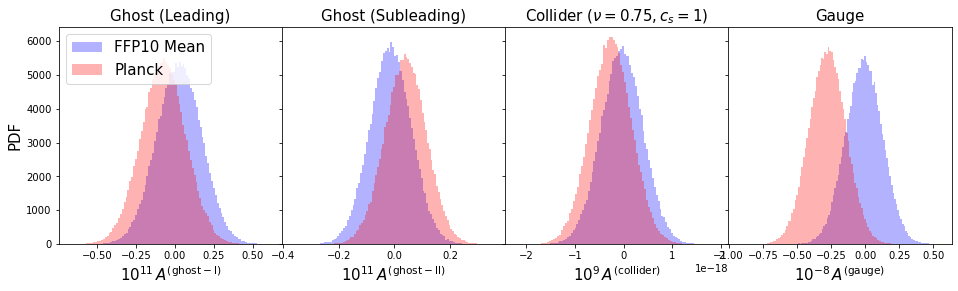

In [47]:
fig, ax = plt.subplots(1,4,figsize=(16,4),sharey=True)
plt.subplots_adjust(wspace=0)
# Ghost-1
ax[0].hist(1e11*samples_mean_ghost1,bins=100,label='FFP10 Mean',alpha=0.3,color='b');
ax[0].hist(1e11*samplesD_ghost1,bins=100,label='Planck',alpha=0.3,color='r');
ax[0].set_xlabel(r'$10^{11}\,A^{(\rm ghost-I)}$',fontsize=15)
ax[0].legend(fontsize=15,loc='upper left');
ax[0].set_title('Ghost (Leading)',fontsize=15)
ax[0].set_ylabel(r'PDF',fontsize=15)
# Ghost-2
ax[1].hist(1e11*samples_mean_ghost2,bins=100,label='FFP10 Mean',alpha=0.3,color='b');
ax[1].hist(1e11*samplesD_ghost2,bins=100,label='Planck',alpha=0.3,color='r');
ax[1].set_xlabel(r'$10^{11}\,A^{(\rm ghost-II)}$',fontsize=15)
ax[1].set_title('Ghost (Subleading)',fontsize=15)
# Collider
ax[2].hist(1e-9*samples_mean_collider1,bins=100,label='FFP10 Mean',alpha=0.3,color='b');
ax[2].hist(1e-9*samplesD_collider1,bins=100,label='Planck',alpha=0.3,color='r');
ax[2].set_xlabel(r'$10^9\,A^{(\rm collider)}$',fontsize=15)
ax[2].set_title(r'Collider ($\nu = 0.75, c_s=1$)',fontsize=15)
# Gauge
ax[3].hist(1e-8*samples_mean_gauge,bins=100,label='FFP10 Mean',alpha=0.3,color='b');
ax[3].hist(1e-8*samplesD_gauge,bins=100,label='Planck',alpha=0.3,color='r');
ax[3].set_xlabel(r'$10^{-8}\,A^{(\rm gauge)}$',fontsize=15)
ax[3].set_title('Gauge',fontsize=15);
fig.savefig('plots/model_results.pdf',bbox_inches='tight')

This completes the analysis. For any questions, email [Oliver Philcox](mailto:ohep2@cantab.ac.uk).